this is for testing the correctedness of my mcmc algorithm with by brutal forcing a path with only 5 reactions. I will also fix the initial copy number. 

In [3]:
import numpy as np
import sys
sys.path.insert(1,'./src/')
from models import ChemicalReactionNetwork
from matplotlib import pyplot as plt
from tqdm import tqdm
import corner
from copy import deepcopy
from statsmodels.tsa.stattools import acf
import joblib

See [description of this notebook](./questions.md/#july-17th-non-abc)

In [4]:
species = 'A B C'.split()
reactions = [
    ({'A': 1}, {'B': 1}),
    ({'B': 1}, {'A': 1}),
    ({'B': 1}, {'C': 1}),
    ({'C': 1}, {'B': 1}),
]

switch_reaction = {
    0: 3,
    1: 2,
    2: 1,
    3: 0
}

kinetic_rates = np.array([2e-1,1,1,2e-1])
# some of the kinetic rates has to equal. 

model = ChemicalReactionNetwork(reactions, species, kinetic_rates)

X_init = np.array([10,20,30])

T = .1

In [5]:
x,r,t = model.gilespie(X_init,T)
len(r)

4

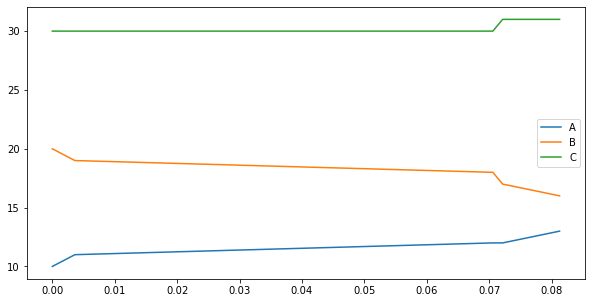

In [6]:
plt.figure(figsize=(10,5))
for i in range(3):
    plt.plot(t,x[:,i],label=species[i])
plt.legend();

the observables are only copy number of `B`, so our observation should be that:


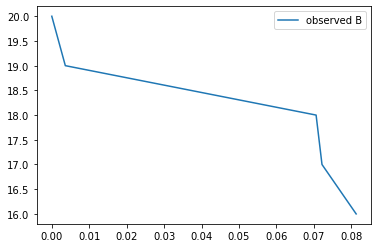

In [7]:
b = model.get_observation(t,x,'B').flatten()
plt.plot(t,b,label='observed B')
plt.legend();

Now, let's think what's in a state:

- reaction time $t_i$
- populations of the 3 species $a_i,b_i,c_i$

So the first step is to generate an initial state based on our observation. 

The observation provides for us the $t_i,a_i$. I will use a random number generator to generate an initial guess of $b_i, c_i$


In [8]:
def get_r(a,c):
    r = np.zeros(len(a)-1,dtype=int)
    
    diff_a = np.diff(a,1)
    diff_c = np.diff(c,1)
    r[diff_a==-1] = 0
    r[diff_a==1] = 1
    r[diff_c==1] = 2
    r[diff_c==-1] = 3
    
    return r

def log_likelihood(state):
    k,a,b,c = state
    r = get_r(a,c)
    X = np.array([a,b,c]).T
    return model.gilespie_exact_log_likelihood(k,X,r,t,T)
    # should this thing be modified a bit? as it is conditioned on fixing b and fixing t. 
    # No, it is still correct up to a constant. so it won't matter in MCMC. 

In [9]:
total_copy_number = np.sum(x[0])
a0 = x[0,0]

def generate_initial_state(b,t,a0=a0,total_copy_number=total_copy_number):
    cond = True
    while cond:
        
        k = np.random.uniform(0,0.5,len(kinetic_rates)) + kinetic_rates
        # a0 = np.random.randint(0,total_copy_number  - b[0])
        
        diff_b = np.diff(b,1) # this equals to '- diff_a - diff_c'
        diff_a = np.zeros(shape=diff_b.shape,dtype=int)
        
        for i,db in enumerate(diff_b):
            if np.random.uniform() < 0.5:
                diff_a[i] = -db
        
        a = np.cumsum(np.insert(diff_a,0,a0))
        c = total_copy_number - a - b
        if np.any(b<0) or np.any(c<0):
            continue
        else:
            log_l = log_likelihood((k,a,b,c))
            cond = (log_l == -np.inf)
    return [k,a,b,c], log_l

def generate_good_initial_state(b,t):
    state,log_l = generate_initial_state(b,t)
    for i in range(20):
        new_state,new_log_l = generate_initial_state(b,t)
        if new_log_l > log_l:
            state = new_state
            likelihood = new_log_l
    return state, new_log_l

In [10]:
true_state = (kinetic_rates,x[:,0],x[:,1],x[:,2])
log_likelihood(true_state)

3.465368286844893

In [11]:
initial_state, init_log_l = generate_good_initial_state(b,t)
k,a,b,c = initial_state
init_log_l

2.583354296315085

Text(0.5, 1.0, 'initial state')

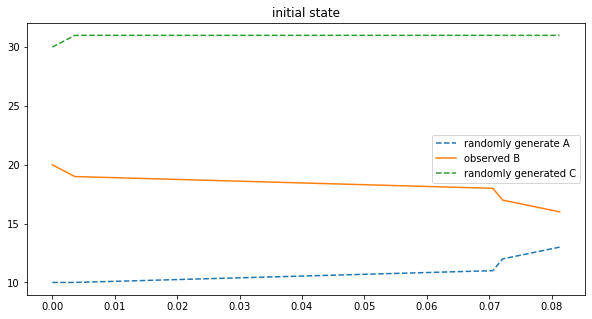

In [12]:
plt.figure(figsize=(10,5))
plt.plot(t,a,'--',label='randomly generate A')
plt.plot(t,b,label='observed B')
plt.plot(t,c, '--', label='randomly generated C')
plt.legend()
plt.title('initial state')

In this particular partial implementation, the only things we can change are 
- kinetic rates
- interchanging reactions 2 and 3. i.e. $B \xLeftrightarrow[k_4]{k_3} C$
- the initial population of the $B,C$

In [13]:
def get_box(k, box_size):

    box = []
    volume = 1

    for t in k:
        lower = max(t-box_size, 0)
        upper = t+box_size
        box.append((lower, upper))
        volume *= (upper-lower)
        
    box = np.array(box).T

    return box, volume

def move_k(state, box_size=min(kinetic_rates)):
    k, a, b, c = deepcopy(state)
    box, volume = get_box(k, box_size)
    new_k = np.random.uniform(*box)

    _, volume2 = get_box(new_k, box_size)

    return (new_k, a, b, c), np.log(volume/volume2)


def get_poss(state):
    _, a, b, c = state
    
    r = np.insert(get_r(a,c),0,-1)
    a_min = np.minimum.accumulate(a[::-1])[::-1]
    c_min = np.minimum.accumulate(c[::-1])[::-1]
    
    possibilities = list(np.where((a_min > 0) & ((r==1) | (r==3)))[0]) + list(np.where((c_min > 0) & ((r==0) | (r==2)))[0])

    # if a_min[0] > 0 :
        # possibilities.append(0)

    # if c_min[0] > 0 :
        # possibilities.append(-1)
    return np.random.choice(possibilities), r, len(possibilities)

def move_copy_number(state,n_steps=1,log_prob=0):
    '''
    this is merged with moving the initial copy number. 
    '''
    if n_steps == 0:
        return state, 0
    if n_steps == 1:
        poss,r,p = get_poss(state)
        k,a,b,c = deepcopy(state)
        
        if poss == 0:
            a += -1
            c += 1
        
        elif poss == -1:
            a += 1
            c += -1
        else:
            if r[poss] in [1,3]:
                a[poss:] += -1
                c[poss:] += 1
            else:
                a[poss:] += 1
                c[poss:] += -1
                
        new_state = (k,a,b,c)
        _,_, q = get_poss(new_state)
        return (k,a,b,c), np.log(p/q) + log_prob
    if n_steps > 1:
        new_state, log_prob = move_copy_number(state,1,log_prob)
        return move_copy_number(new_state,n_steps-1,log_prob)

In [14]:
def mcmc(initial_state, n):

    samples = [initial_state]
    if_accepted = []
    log_likelihoods = [log_likelihood(initial_state)]

    for i in tqdm(range(n), desc='sampling state space'):
        
        if np.random.uniform() < 0.5:
            move = 1
            new_state, log_p = move_copy_number(samples[-1],n_steps=1)
        else:
            move = 2
            new_state, log_p = move_k(samples[-1])
        
        curr_log_pst = log_likelihood(new_state)
        log_acceptance = curr_log_pst + log_p - log_likelihoods[-1]
        if log_acceptance >= 0 or np.log(np.random.uniform()) < log_acceptance:
            samples.append(new_state)
            log_likelihoods.append(curr_log_pst)
            if_accepted.append(move)
        else:
            samples.append(samples[-1])
            log_likelihoods.append(log_likelihoods[-1])
            if_accepted.append(0)
    return samples, np.array(if_accepted), np.array(log_likelihoods)

I am going to have a test on the move_state function

In [15]:
pst_samples,if_accepcted, log_likelihoods = mcmc(initial_state, n=int(2e5))

sampling state space: 100%|██████████| 200000/200000 [01:46<00:00, 1881.44it/s]


In [16]:
print('rejection rate:', np.sum(if_accepcted==0)/len(if_accepcted))
print('moving path:', np.sum(if_accepcted==1)/len(if_accepcted))
print('moving kinetic rates:', np.sum(if_accepcted==2)/len(if_accepcted))

rejection rate: 0.38957
moving path: 0.2489
moving kinetic rates: 0.36153


In [17]:
pst_k = np.array([i[0] for i in pst_samples])

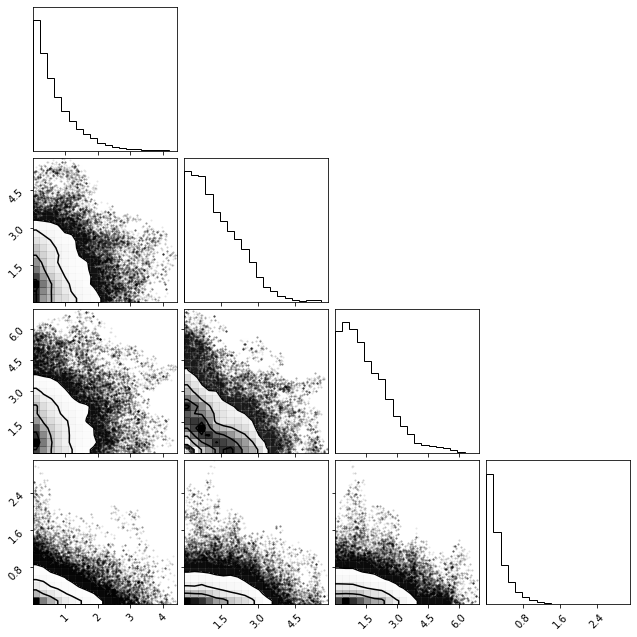

In [18]:
corner.corner(pst_k[1000:]);

Text(0.5, 1.0, 'autocorrelation of k1')

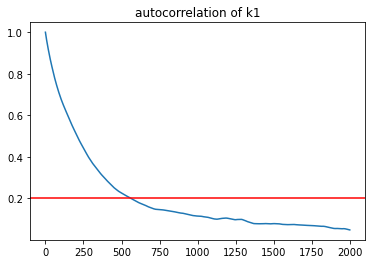

In [19]:
plt.plot(acf(pst_k[1000:,0],nlags=2000))
plt.axhline(0.2, color='r')
plt.title('autocorrelation of k1')

In [20]:
log_likelihood(pst_samples[-1])

1.4129235878635038

In [21]:
log_likelihood(true_state)

3.465368286844893

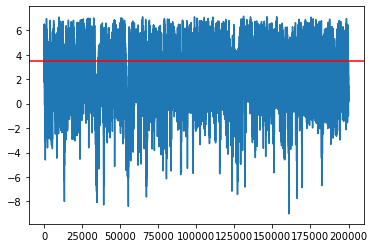

In [22]:
plt.plot(log_likelihoods,label='log likelihoods of MCMC samples')
plt.axhline(log_likelihood(true_state), color='r', label='true state')

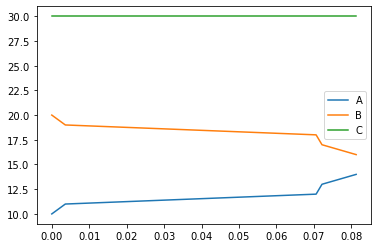

In [23]:
for i in range(3):
    plt.plot(t,pst_samples[np.argmax(log_likelihoods)][i+1], label=model.index2chemical[i])
plt.legend();

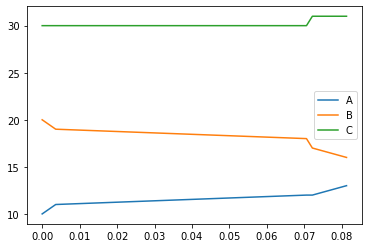

In [24]:
for i in range(3):
    plt.plot(t,true_state[i+1], label=model.index2chemical[i])
plt.legend();

# Brute-Force evaluating the log likelihoods

- generate a grid of $k$ 
- find all the possible full observations, which is just 2

In [25]:
def get_all_path(b,a0=a0):
    
    diff_b = np.diff(b,1) # this equals to '- diff_a - diff_c'
    path = []
    for i in range(2**(len(b)-1)):        
    
        diff_a = np.zeros(shape=diff_b.shape,dtype=int)
        
        for j,db in enumerate(diff_b):
            if (i>>j) % 2 == 0:
                diff_a[j] = -db
        
        a = np.cumsum(np.insert(diff_a,0,a0))
        c = total_copy_number - a - b
        if np.any(b<0) or np.any(c<0):
            continue
        else:
            path.append(np.array((a,b,c)).T)
    return path

In [26]:
paths = get_all_path(b)

In [27]:
kinetic_rates

array([0.2, 1. , 1. , 0.2])

In [28]:
upper_bound = np.quantile(pst_k,q= 0.95, axis=0)
upper_bound

array([2.05006461, 3.11484106, 3.74380705, 0.83854025])

In [29]:
lower_bound = np.quantile(pst_k,q= 0.05, axis=0)
lower_bound

array([0.03772259, 0.10137529, 0.12910458, 0.01314491])

I will use data to make the grid

In [30]:
grid1, grid2, grid3, grid4 = np.meshgrid(*[np.linspace(lower_bound[i], upper_bound[i],50) for i in range(4)])

In [31]:
grid1 = grid1.flatten()
grid2 = grid2.flatten()
grid3 = grid3.flatten()
grid4 = grid4.flatten()

In [35]:
def brute_force_log_likelihood(i,j):
    k = np.array((grid1[i],grid2[i],grid3[i],grid4[i]))
    path = paths[j]
    a = path[:,0]
    b = path[:,1]
    c = path[:,2]
    return log_likelihood((k,a,b,c))

In [38]:
brute_force_log_l = joblib.Parallel(n_jobs=8,batch_size=1024)(joblib.delayed(brute_force_log_likelihood)(i,j) for j in range(len(paths)) for i in range(len(grid1)))

KeyboardInterrupt: 